In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from herbario import pipeline

## Set basic configuration

In [2]:
# Recommended on documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True

## Define some utilities

In [3]:
def enforce_dir(path: str):
    """Accepts path separated as strings.
    Creates directory in case it doesn't exist"""
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

## Get Rasgos-CL data
The datasets are located at GitHub.com, inside a public repository.

In [4]:
traits_url = "https://raw.githubusercontent.com/dylancraven/Rasgos-CL/main/Data/RasgosCL_aggregatedspp.csv"
try:
    traits_df = pd.read_csv(traits_url)
except Exception as err:
    print(f"Error when downloading: {err}")

We also need a secondary dataset for geographical references:

In [5]:
geo_url = "https://raw.githubusercontent.com/dylancraven/Rasgos-CL/main/Extra/Chile_spp_distrib.csv"
try:
    geo_df = pd.read_csv(geo_url)
except Exception as err:
    print(f"Error when downloading: {err}")

## Get HerbarioDigital's data

In [24]:
herbario_species = pipeline()

Reusing last species file


# First species exploration


In [7]:
traits_df.info(), traits_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8643 entries, 0 to 8642
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   accepted_species  8643 non-null   object 
 1   traitValue        8643 non-null   object 
 2   obs               8413 non-null   float64
 3   traitName         8643 non-null   object 
 4   agreement         7256 non-null   float64
 5   traitUnit         8643 non-null   object 
dtypes: float64(2), object(4)
memory usage: 405.3+ KB


(None,
                obs    agreement
 count  8413.000000  7256.000000
 mean      3.020088     0.986776
 std       3.956636     0.057783
 min       1.000000     0.666667
 25%       1.000000     1.000000
 50%       2.000000     1.000000
 75%       4.000000     1.000000
 max     116.000000     1.000000)

In [8]:
traits_df.sample(5)

,accepted_species,traitValue,obs,traitName,agreement,traitUnit
3206,Eriosyce subgibbosa,1.5,5.0,Max_plant_height,NaN,m
4716,Heliotropium pycnophyllum,Evergreen,2.0,Leaf_habit,1.0,"Deciduous, Evergreen, Variable"
2681,Cryptocarya alba,Biotic,10.0,Dispersal_syndrome_1,1.0,"Abiotic, Biotic, Multiple, No_syndrome"
3034,Eriosyce chilensis,Shrub,1.0,Growth_form,1.0,"Tree, Shrub_SmallTree, Shrub"
481,Adesmia monosperma,Compound,1.0,Leaf_organization_1,1.0,"Compound, Simple, Variable"


# Reordering Dataframe & filtering relevant data
We want to know how studied the species are, which means we can reduce the size of our dataset.

In [9]:
df_ordered = traits_df[["accepted_species", "traitName", "obs"]]
df_ordered.rename(columns={"accepted_species": "specie", "traitName": "trait_name"}, inplace=True)

In [10]:
observed_species = df_ordered.groupby("specie").agg({"obs": ["sum"]})
observed_species.columns = ["total_observations"]
observed_species.head()

,total_observations
specie,
Acrisione cymosa,27.0
Acrisione denticulata,49.0
Adenopeltis serrata,39.0
Adesmia aphylla,18.0
Adesmia argentea,25.0


# Geographical data exploration

In [11]:
geo_df.head()

,accepted_species,region,presencia
0,Acrisione cymosa,AIS,1
1,Acrisione cymosa,ANT,0
2,Acrisione cymosa,ARA,1
3,Acrisione cymosa,ATA,0
4,Acrisione cymosa,AYP,0


In [12]:
geo_df.loc[:, "region"].unique()

array(['AIS', 'ANT', 'ARA', 'ATA', 'AYP', 'BIO', 'COQ', 'IPA', 'JFE',
       'LBO', 'LLA', 'LRI', 'MAG', 'MAU', 'NUB', 'RME', 'TAR', 'VAL'],
      dtype=object)

In [13]:
new_regions = {
    'AIS': 'Aysén',
    'ANT': 'Antofagasta',
    'ARA': 'Araucanía',
    'ATA': 'Atacama',
    'AYP': 'Arica y Parinacota',
    'BIO': 'Bío-Bío',
    'COQ': 'Coquimbo',
    'IPA': 'Isla de Pascua',
    'JFE': 'Juan Fernández',
    'LBO': 'Libertador Bernardo O\'Higgins',
    'LLA': 'Los Lagos',
    'LRI': 'Los Ríos',
    'MAG': 'Magallanes',
    'MAU': 'Maule',
    'NUB': 'Ñuble',
    'RME': 'Metropolitana',
    'TAR': 'Tarapacá',
    'VAL': 'Valparaíso'
}
geo_df.columns = ["specie", "location", "is_present"]
geo_df.replace(to_replace=new_regions, inplace=True)

In [14]:
location_dataframes = list()
grouped = geo_df.groupby("specie")[["location", "is_present"]]
for specie_name in grouped.groups.keys():
    specie_df = grouped.get_group(specie_name).set_index("location").T
    specie_df.index = [specie_name]
    specie_df.columns.names = [""]
    location_dataframes.append(specie_df)

located_species_df = pd.concat(location_dataframes)


In [15]:
located_species_df.fillna(0, inplace=True)
located_species_corrected_df = located_species_df.astype('int64')
located_species_corrected_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, Acrisione cymosa to Weinmannia trichosperma
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Aysén                          718 non-null    int64
 1   Antofagasta                    718 non-null    int64
 2   Araucanía                      718 non-null    int64
 3   Atacama                        718 non-null    int64
 4   Arica y Parinacota             718 non-null    int64
 5   Bío-Bío                        718 non-null    int64
 6   Coquimbo                       718 non-null    int64
 7   Isla de Pascua                 718 non-null    int64
 8   Juan Fernández                 718 non-null    int64
 9   Libertador Bernardo O'Higgins  718 non-null    int64
 10  Los Lagos                      718 non-null    int64
 11  Los Ríos                       718 non-null    int64
 12  Magallanes                     718 non-null    i

In [28]:
observed_located_species = pd.merge(observed_species, located_species_corrected_df, left_index=True, right_index=True)
observed_located_species.head()

,total_observations,Aysén,Antofagasta,Araucanía,Atacama,Arica y Parinacota,Bío-Bío,Coquimbo,Isla de Pascua,Juan Fernández,Libertador Bernardo O'Higgins,Los Lagos,Los Ríos,Magallanes,Maule,Ñuble,Metropolitana,Tarapacá,Valparaíso
specie,,,,,,,,,,,,,,,,,,,
Acrisione cymosa,27.0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1
Acrisione denticulata,49.0,0,0,1,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1
Adenopeltis serrata,39.0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,1,0,1
Adesmia aphylla,18.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Adesmia argentea,25.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1


# Exploring HerbarioDigital's data

In [25]:
herbario_species.head()

,Unnamed: 0,id,scientific_name,habit,status,conservation_state,Araucanía,Maule,Atacama,Antofagasta,...,Libertador Bernardo O'Higgins,Arica y Parinacota,Los Ríos,Ñuble,Coquimbo,Los Lagos,Magallanes,Bío-Bío,Valparaíso,Aysén
0,0,1583,Acrisione cymosa,Bush or Small tree,Endemic,Not Evaluated (NE),1,0,0,0,...,0,0,1,0,0,1,0,1,1,1
1,1,5567,Acrisione denticulata,Bush,Native,Not Evaluated (NE),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1585,Acrisione denticulata var. pilota,Bush,Endemic,Not Evaluated (NE),1,1,0,0,...,1,0,0,1,1,1,0,1,1,0
3,3,3523,Adenopeltis serrata,Bush,Endemic,Not Evaluated (NE),0,1,0,0,...,1,0,0,1,1,0,0,1,1,0
4,4,3587,Adesmia aphylla,Bush,Endemic,Not Evaluated (NE),0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [34]:
clean_herbario_df = herbario_species.drop(labels=["Unnamed: 0"], axis=1)
clean_herbario_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   id                             742 non-null    int64 
 1   scientific_name                742 non-null    object
 2   habit                          742 non-null    object
 3   status                         737 non-null    object
 4   conservation_state             742 non-null    object
 5   Araucanía                      742 non-null    int64 
 6   Maule                          742 non-null    int64 
 7   Atacama                        742 non-null    int64 
 8   Antofagasta                    742 non-null    int64 
 9   Juan Fernández                 742 non-null    int64 
 10  Tarapacá                       742 non-null    int64 
 11  Metropolitana                  742 non-null    int64 
 12  Libertador Bernardo O'Higgins  742 non-null    int64 
 13  Arica

# Merging final df

In [48]:
merged = pd.merge(observed_located_species, herbario_species, left_index=True, right_on="scientific_name", how="outer", suffixes=("", "_herbario"))
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 834 entries, 0.0 to 741.0
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   total_observations                      722 non-null    float64
 1   Aysén                                   722 non-null    float64
 2   Antofagasta                             722 non-null    float64
 3   Araucanía                               722 non-null    float64
 4   Atacama                                 722 non-null    float64
 5   Arica y Parinacota                      722 non-null    float64
 6   Bío-Bío                                 722 non-null    float64
 7   Coquimbo                                722 non-null    float64
 8   Isla de Pascua                          722 non-null    float64
 9   Juan Fernández                          722 non-null    float64
 10  Libertador Bernardo O'Higgins           722 non-null    float64

In [70]:
region_columns = [region.split("_")[0] for region in merged.columns if "_herbario" in region]

unified_regions = merged
for region in region_columns:
    unified_regions[region] = unified_regions.apply(lambda row: row[f'{region}_herbario'] if (row[region]==0 or np.isnan(row[region])) and not np.isnan(row[f'{region}_herbario']) else row[region], axis=1)

unified_regions.head()


,total_observations,Aysén,Antofagasta,Araucanía,Atacama,Arica y Parinacota,Bío-Bío,Coquimbo,Isla de Pascua,Juan Fernández,...,Arica y Parinacota_herbario,Los Ríos_herbario,Ñuble_herbario,Coquimbo_herbario,Los Lagos_herbario,Magallanes_herbario,Bío-Bío_herbario,Valparaíso_herbario,Aysén_herbario,Araucanía_new
0.0,27.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1.0,49.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2.0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
3.0,39.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4.0,18.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
simplified_columns = ["scientific_name", "total_observations", "habit", "status", "conservation_state"]
simplified_columns.extend(region_columns)

simplified_df = unified_regions.loc[:, simplified_columns]
# Add location score by showing total region presence
simplified_df["location_score"] = simplified_df.loc[:, region_columns].sum(axis=1)
simplified_df.head()

,scientific_name,total_observations,habit,status,conservation_state,Araucanía,Maule,Atacama,Antofagasta,Juan Fernández,...,Arica y Parinacota,Los Ríos,Ñuble,Coquimbo,Los Lagos,Magallanes,Bío-Bío,Valparaíso,Aysén,location_score
0.0,Acrisione cymosa,27.0,Bush or Small tree,Endemic,Not Evaluated (NE),1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,6.0
1.0,Acrisione denticulata,49.0,Bush,Native,Not Evaluated (NE),1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,10.0
2.0,Acrisione denticulata var. pilota,NaN,Bush,Endemic,Not Evaluated (NE),1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,9.0
3.0,Adenopeltis serrata,39.0,Bush,Endemic,Not Evaluated (NE),0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,7.0
4.0,Adesmia aphylla,18.0,Bush,Endemic,Not Evaluated (NE),0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [157]:
clean_df = simplified_df.dropna(subset=["total_observations"])

column_fillna = {region: 0 for region in region_columns}
column_fillna["total_observations"] = 0
column_fillna["conservation_state"] = "Not Applicable (N/A)"

clean_df.fillna(column_fillna, inplace=True)

In [158]:
clean_df.sort_values(by="total_observations", ascending=False)

,scientific_name,total_observations,habit,status,conservation_state,Araucanía,Maule,Atacama,Antofagasta,Juan Fernández,...,Arica y Parinacota,Los Ríos,Ñuble,Coquimbo,Los Lagos,Magallanes,Bío-Bío,Valparaíso,Aysén,location_score
500.0,Maytenus boaria,250.0,Tree,Native,Not Evaluated (NE),1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0
NaN,Drimys winteri,230.0,NaN,NaN,Not Applicable (N/A),1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0
589.0,Persea lingue,218.0,Tree,Native,Least Concern (LC),1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,9.0
733.0,Vachellia caven,207.0,Tree,Native,Not Evaluated (NE),1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,10.0
NaN,Prosopis tamarugo,189.0,NaN,NaN,Not Applicable (N/A),0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650.0,Senecio coscayanus,4.0,Bush,Endemic,Not Evaluated (NE),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
130.0,Baccharis pilcensis,4.0,Bush,Endemic,Not Evaluated (NE),0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
118.0,Baccharis cymosa,4.0,Bush,Endemic,Not Evaluated (NE),0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
496.0,Lycium rachidocladum,4.0,Bush,Endemic,Not Evaluated (NE),0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


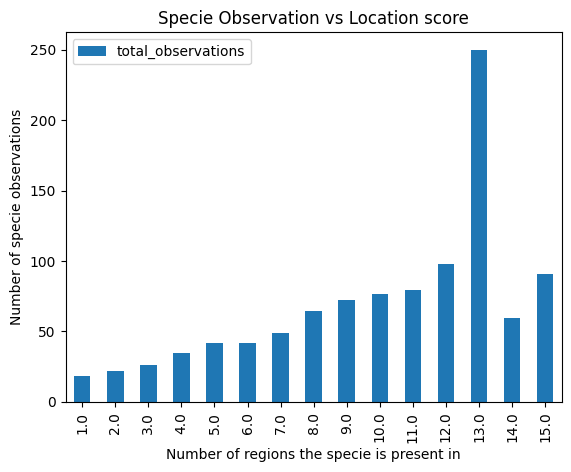

In [214]:
obs_per_location = clean_df.loc[:, ["location_score", "total_observations"]].groupby("location_score").mean().sort_values("location_score")

obs_per_location.plot.bar(
    title="Specie Observation vs Location score",
    xlabel="Number of regions the specie is present in",
    ylabel="Number of specie observations",
)
plt.show()

Yes, that's the reason.
To get reliable insights, we should weight the observations by the number of species in such state

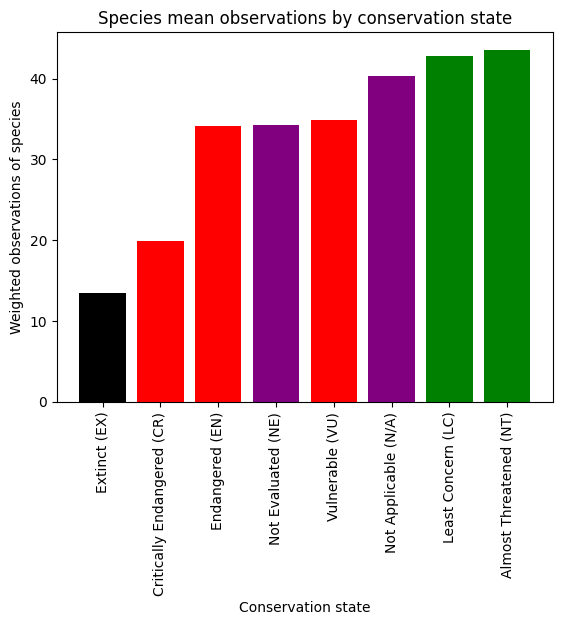

In [266]:
state_obs = clean_df.loc[:, ["total_observations", "conservation_state"]].groupby("conservation_state").mean().sort_values("total_observations").reset_index()

plt.bar(state_obs.conservation_state, state_obs.total_observations, color=["black", "red", "red", "purple", "red", "purple", "green", "green"])
plt.xticks(rotation=90)
plt.title("Species mean observations by conservation state")
plt.xlabel("Conservation state")
plt.ylabel("Weighted observations of species")
plt.show()

This also confirms our suspicions that more endangered species are less studied, probably because of the lack of specimens found in the wild.
The less threatened a specie is, the more relative observations it gets.

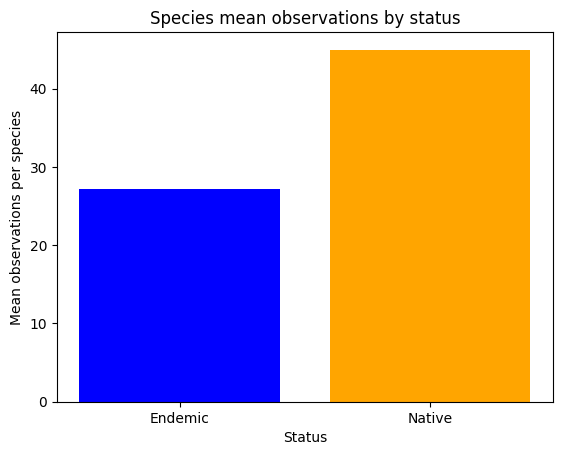

In [265]:
status_obs = clean_df.loc[:, ["total_observations", "status"]].groupby("status").mean().sort_values("total_observations").reset_index()

plt.bar(status_obs.status, status_obs.total_observations, color=["blue", "orange"])
plt.title("Species mean observations by status")
plt.xlabel("Status")
plt.ylabel("Mean observations per species")
plt.show()

By definition, an endemic specie might be harder to spot as it doesn't survive when placed in foreign habitats.
This might be corroborated by looking at the location score vs the status of the species:

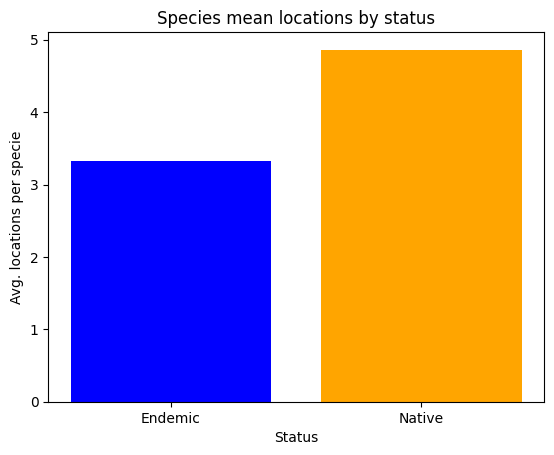

In [264]:
status_locations = clean_df.loc[:, ["status", "location_score"]].groupby("status").mean().sort_values("location_score").reset_index()

plt.bar(status_locations.status, status_locations.location_score, color=["blue", "orange"])
plt.title("Species mean locations by status")
plt.xlabel("Status")
plt.ylabel("Avg. locations per specie")
plt.show()

Finally, let's see if the plant's habit has a correlation with its number of observations.

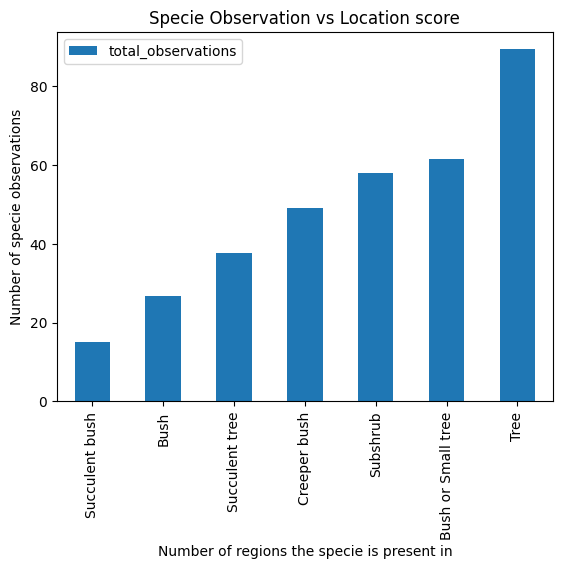

In [267]:
obs_per_habit = clean_df.loc[:, ["habit", "total_observations"]].groupby("habit").mean().sort_values("total_observations")

obs_per_habit.plot.bar(
    title="Specie Observation vs Location score",
    xlabel="Number of regions the specie is present in",
    ylabel="Number of specie observations",
)
plt.show()

# References:

- Working with groups: https://realpython.com/pandas-groupby/#example-1-us-congress-dataset
- IUCN Red List of Threatened Species: https://en.wikipedia.org/wiki/Conservation_status